In [1]:
import datapackage
import pandas as pd
from io import StringIO
import requests
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from quarantine import quarantine

In [2]:
def getdata(data_url = 'https://datahub.io/core/covid-19/datapackage.json', resourcename='countries-aggregated_csv'):
    """
    Get data from the web
    data_url : string with url of the data from datahub
    resourcename : resource to use
    """

    # to load Data Package into storage
    package = datapackage.Package(data_url)
    resources = package.resources

    for resource in resources:
        if resource.name == resourcename:
            url=resource.descriptor['path']
            print('Importing',url)
            s=requests.get(url).text
            data = pd.read_csv(StringIO(s))
    return data

In [3]:
def readdata(filenamebase='data/covid_data_',date=datetime.date.today().isoformat()):
    """
    Reads the data from CSV file
    
    Parameters:
    
    filenamebase : basename of the saved file. Full filename is filenamebase + date + '.csv'
    date : date of the data. Default: today's date 
    
    Output:
    
    pd.DataFrame
    
    """
    filename='%s%s.csv' % (filenamebase,date)
    with open(filename,'r') as file:
        data=pd.read_csv(file)
    return data

In [4]:
def savedata(dataframe,filenamebase='data/covid_data_',date=datetime.date.today().isoformat()):
    """
    Save the dataframe as CSV file
    
    Parameters
    ----------

    dataframe : pd.DataFrame to save. Default 'covid_data_'
    filenamebase : basename of the saved file. Full filename is filenamebase + date + '.csv'
    date : date of the data. Default: today's date
    """
    filename='%s%s.csv' % (filenamebase,date)
    with open(filename,'w') as file:
        dataframe.to_csv(file,index=False)

In [5]:
defaultcountrylist=('Colombia', 'Italy', 'US')
d=getdata()
def builddatalist(indicator = 'Confirmed', minindicator=1, countrylist=defaultcountrylist, fulldata=d):
    """
    Build a list of data for selected countries 
    
    Parameters
    ----------
    indicator : indicator to shift the time series
    minindicator : value to start the time series. 
        Day 0 corresponds to the day when indicator >= minindicator
    countrylist : list of countries to build the datalist
    fulldata : raw data for all countries
    """
    datalist={}
    for country in countrylist:
        dat=fulldata[fulldata['Country']==country]
        dat=dat[dat[indicator]>=minindicator]
        dat['Day']=np.arange(len(dat))
        datalist[country]=dat
    return datalist

Importing https://pkgstore.datahub.io/core/covid-19/countries-aggregated_csv/data/1d1988619760aa27906ca3ef022db9e7/countries-aggregated_csv.csv


In [7]:
savedata(d)

In [6]:
def plotdata(indicator = 'Confirmed', minindicator=1, dayrange = {'min': 0, 'max' : -1}, 
             logscale=True, countrylist=defaultcountrylist, fulldata=d):
    """
    Plots data for selected countries and indicator
    
    Parameters
    ----------
    indicator : indicator to shift the time series
    minindicator : value to start the time series. 
        Day 0 corresponds to the day when indicator >= minindicator
    dayrange : dict with min, max range to plot. max=-1 is plot all
    logscale: plot in logscale (True) or linear (False)
    countrylist : list of countries to build the datalist
    fulldata : raw data for all countries
    """
    datalist=builddatalist(indicator, minindicator, countrylist, d)
    yax=indicator
    fig, ax = plt.subplots(figsize=(12,6))
    for country in countrylist:
        color = next(ax._get_lines.prop_cycler)['color']
        df=datalist[country]
        df=df[dayrange['min'] <= df['Day']]
        if dayrange['max']!=-1 :
            df=df[df['Day']<=dayrange['max']]
        # Get day 0 date
        dayzero_df=df[df['Day']==0]
        dayzero_date=dayzero_df.at[dayzero_df.index[-1],'Date']
        df.plot(x='Day',y=yax,logy=logscale,label='%s day 0: %s' % (country,dayzero_date),ax=ax, color=color)
        # get quarantine day info
        try:
            quarantine_date=quarantine[country]
        except KeyError:
            print('%s not in quarantine'%(country))
        else:
            quarantine_day_df=df[df['Date']==quarantine_date]
           #     print(quarantine_day_df)
            try:
                quarantine_day=quarantine_day_df.at[quarantine_day_df.index[-1],'Day']
           #    print(quarantine_day)
            except IndexError:
                # Quarantine date is out of bounds
                print('%s quarantine date %s out of bounds. Day zero is %s' %(country,quarantine_date, dayzero_date))
            else:
                ax.axvline(x=quarantine_day, color=color,
                           label='%s quarantine on day %d (%s)' % (country,quarantine_day,quarantine_date))
    ax.set_ylabel(yax)
    ax.set_xlabel('Days from first day when "'+indicator+'" >='+str(minindicator))
    if logscale:
        labellog = ' (log scale)'
    else:
        labellog = ''   
    ax.set_title(indicator+' covid-19' + labellog)
    ax.grid()
    ax.legend()
    return fig

US not in quarantine


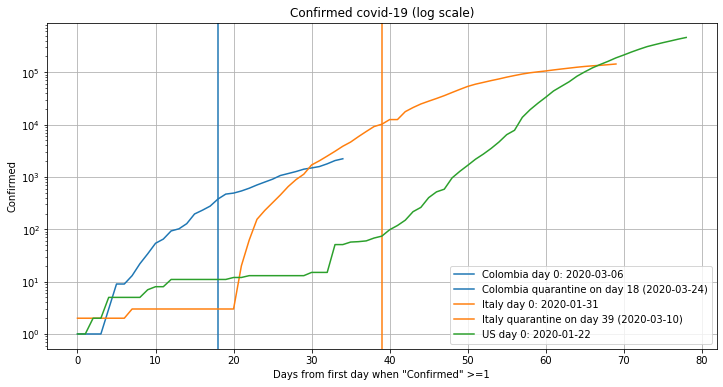

In [9]:
plotdata();

US not in quarantine


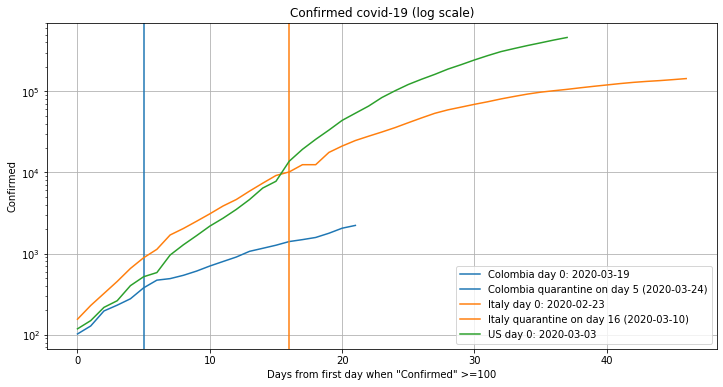

In [10]:
figc100=plotdata(minindicator=100)

Colombia quarantine date 2020-03-24 out of bounds. Day zero is 2020-03-29
US not in quarantine


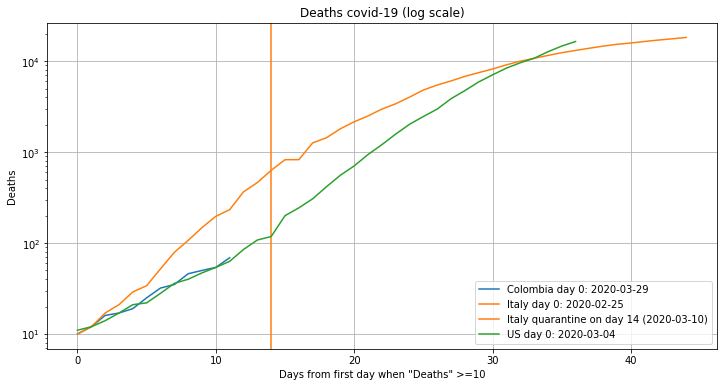

In [11]:
figd10=plotdata(indicator='Deaths', minindicator=10)

US not in quarantine


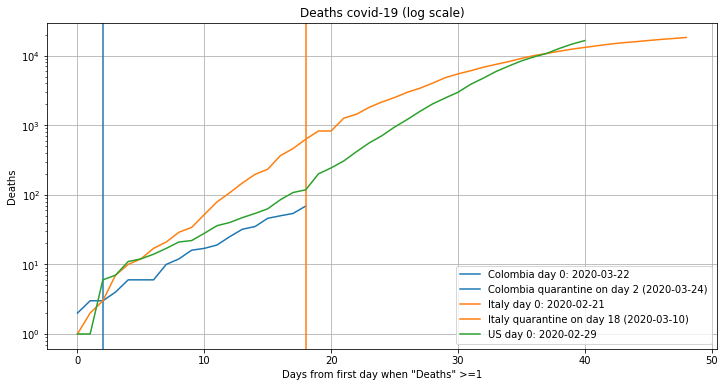

In [12]:
plotdata(indicator='Deaths', minindicator=1);

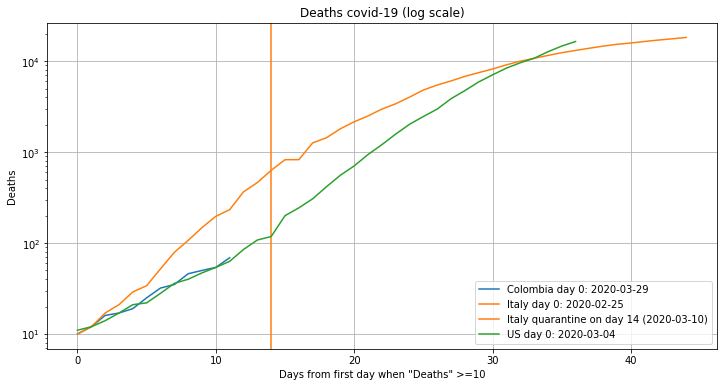

In [13]:
figd10

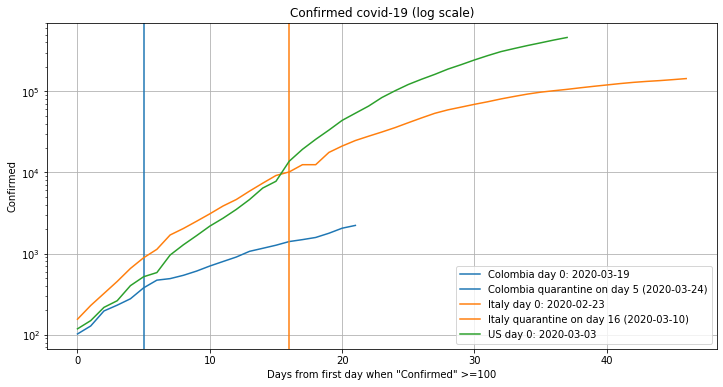

In [14]:
figc100

US not in quarantine


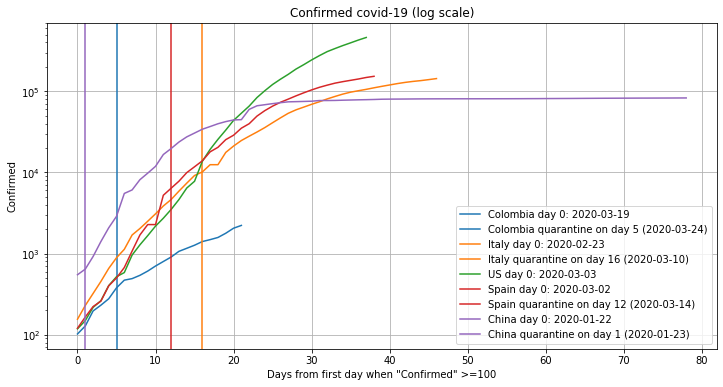

In [15]:
plotdata(countrylist=defaultcountrylist+('Spain','China'),minindicator=100);

Colombia quarantine date 2020-03-24 out of bounds. Day zero is 2020-03-27
US not in quarantine


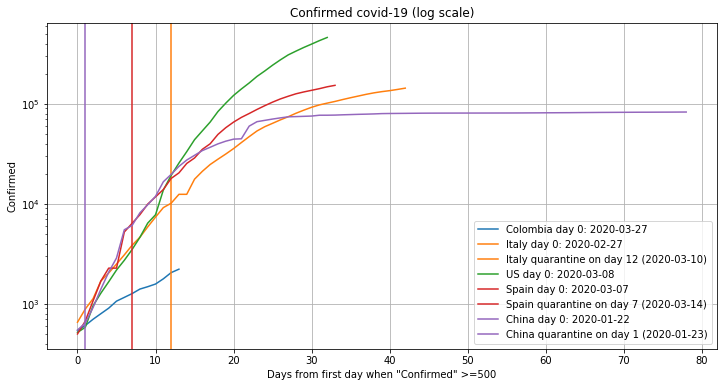

In [16]:
plotdata(countrylist=defaultcountrylist+('Spain','China'),minindicator=500);

Colombia quarantine date 2020-03-24 out of bounds. Day zero is 2020-03-29
US not in quarantine


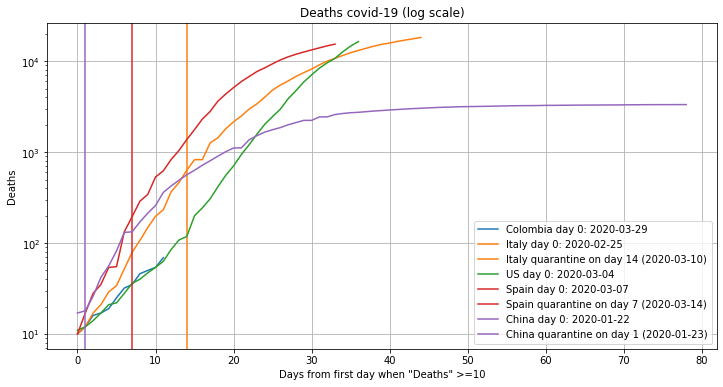

In [17]:
plotdata(countrylist=defaultcountrylist+('Spain','China'),indicator='Deaths',minindicator=10);